# Clasificación de enfermedades en cultivos de papa
### Proyecto Final
Angie Natalia Mojica - Daniel Antonio Santanilla

## Dataset

Se carga el dataset previamente creado y almacenado en Hugging Face

In [ ]:
!pip install datasets

In [30]:
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

In [5]:
from datasets import load_dataset

dataset = load_dataset("ELS4NTA/enfermedades_hoja_papa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8225 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2350 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1175 [00:00<?, ? examples/s]

## Preprocesamiento de datos

In [ ]:
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

In [6]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
print(id2label)

{'0': 'Late Blight', '1': 'Pudricion_Parda', '2': 'Sana', '3': 'Tizon_Temprano', '4': 'Virus'}


In [8]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [9]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [10]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [11]:
dataset = dataset.with_transform(transforms)

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Definición de métricas

In [13]:
import evaluate

accuracy = evaluate.load("accuracy")

In [14]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Entrenando el modelo ViT

In [15]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Se inicia sesión en hugging para subir el modelo

In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
training_args = TrainingArguments(
    output_dir="greenguardian_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TrainOutput(global_step=384, training_loss=0.2690610713325441, metrics={'train_runtime': 1229.0546, 'train_samples_per_second': 20.076, 'train_steps_per_second': 0.312, 'total_flos': 1.9021695213358817e+18, 'train_loss': 0.2690610713325441, 'epoch': 2.9825242718446603})

In [19]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/AngieMojica/greenguardian_model/commit/4bd49485a6c96c626824c0c55647df52338cfd50', commit_message='End of training', commit_description='', oid='4bd49485a6c96c626824c0c55647df52338cfd50', pr_url=None, pr_revision=None, pr_num=None)

## Resultados

In [26]:
y_label_test = trainer.predict(dataset["test"])

In [27]:
logits = y_label_test.predictions

# Aplicar softmax a los logits para obtener probabilidades
probabilidades = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

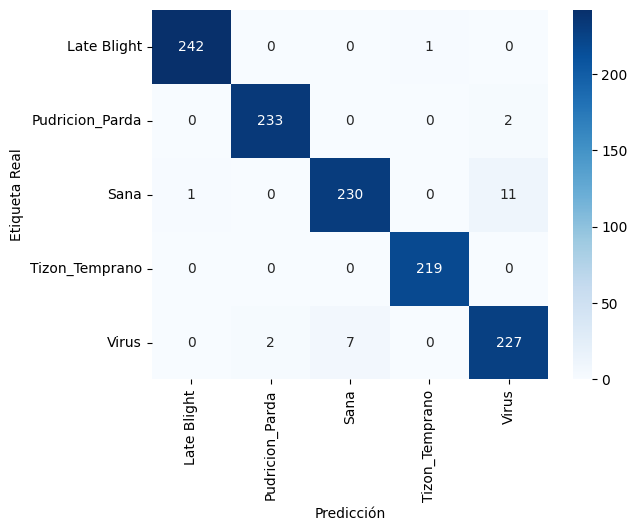

In [33]:
from sklearn.metrics import confusion_matrix

predicted_labels = np.argmax(probabilidades, axis=1)

cm = confusion_matrix(y_label_test.label_ids, predicted_labels)

labels = list(id2label.values())

# Crear el heatmap con las etiquetas
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


### Casos de Verdaderos Negativos y Falsos Negativos

In [39]:
dataset_images = load_dataset("ELS4NTA/enfermedades_hoja_papa")

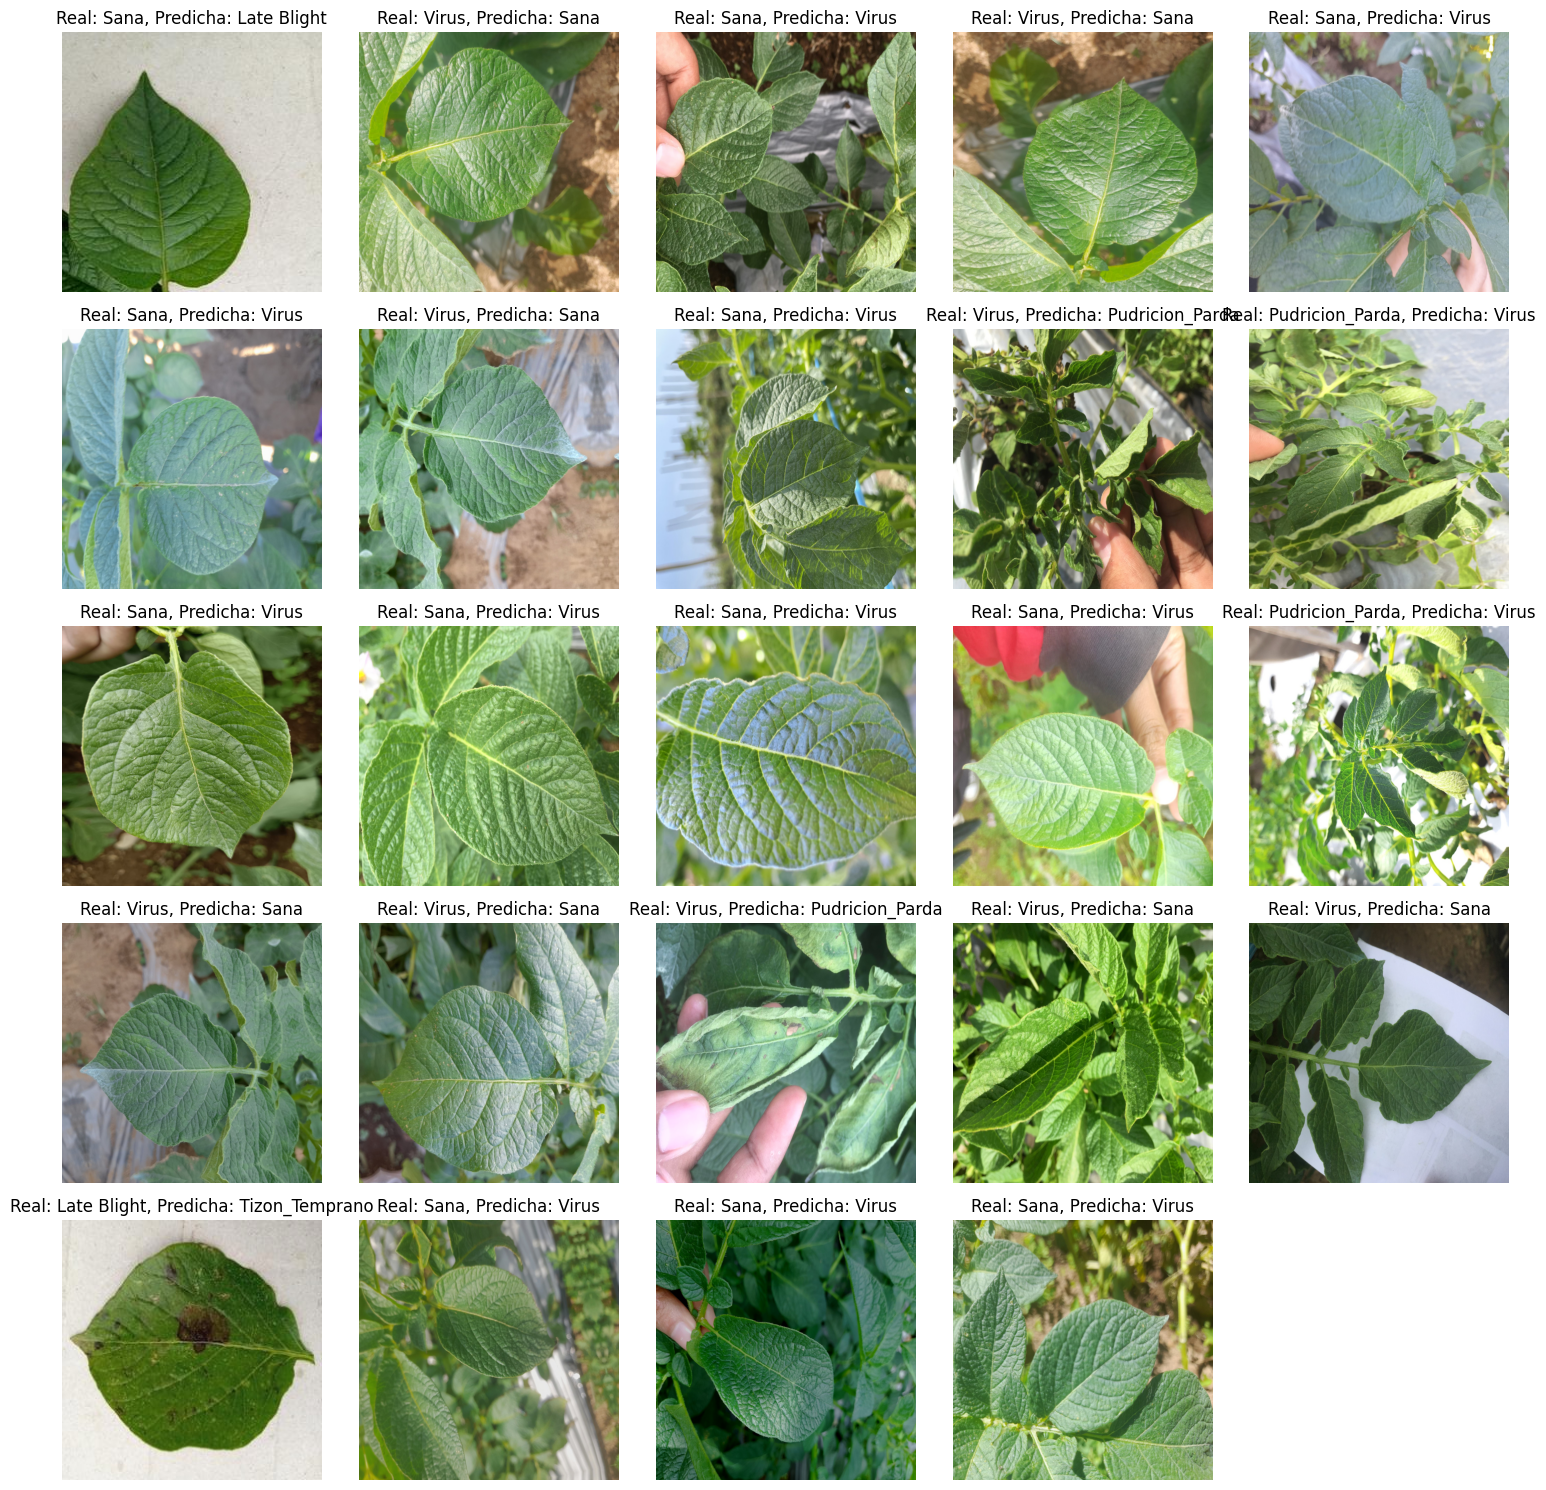

In [42]:
indices_incorrectos = np.where(predicted_labels != y_label_test.label_ids)[0]
imagenes_incorrectas = dataset_images['test'].select(indices_incorrectos)['image']
etiquetas_reales = dataset_images['test'].select(indices_incorrectos)['label']
etiquetas_predichas = predicted_labels[indices_incorrectos]

# Calcular el número de filas necesarias para mostrar las imágenes
num_imagenes = len(imagenes_incorrectas)
num_filas = (num_imagenes - 1) // 5 + 1

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=num_filas, ncols=5, figsize=(15, 3 * num_filas))

# Aplanar la matriz de axes para facilitar la iteración
axes = axes.ravel()

# Mostrar las imágenes incorrectas con etiquetas de texto, 5 por fila
for i, imagen in enumerate(imagenes_incorrectas):
    # Mostrar imagen en el subplot correspondiente
    axes[i].imshow(imagen)
    axes[i].set_title(f"Real: {id2label[str(etiquetas_reales[i])]}, Predicha: {id2label[str(etiquetas_predichas[i])]}")

    # Ocultar ejes
    axes[i].axis('off')

# Ocultar los subplots vacíos (si hay menos de 5 imágenes en la última fila)
for j in range(num_imagenes, num_filas * 5):
    axes[j].axis('off')

# Ajustar el diseño para evitar superposición de títulos
plt.tight_layout()
plt.show()